# Homework 1: Data Preparation and Exploratory Data Analysis
## CIS600
## Evan Smith

### Data Cleaning
First, we import the data from disk.

In [407]:
import pandas as pd

#slightly different paths per dev machine I used for this work
#ret = pd.read_csv("C:/Users/evana/source/repos/Syracuse_Grad/CIS_600_Fund_Data_Mining/HW1/employee_attrition.csv")
ret = pd.read_csv("C:/Users/evana/Documents/GitHub/SyracuseMasters/CIS_600_Fund_Data_Mining/HW1/employee_attrition.csv")

We then define a function to display null data. We want to minimize the impact of these values on our overall data health.

In [1]:
def DisplayNullRows (df):
    dataCleaningCounts = []
    for col in df.columns:
        nullsCount = df[col].isnull().sum()
        if nullsCount > 0:
            dataCleaningCounts.append([col, df[col].nunique(), nullsCount])

    display(pd.DataFrame(dataCleaningCounts, columns = ['Column', 'Unique Values', 'Nulls']))
    return

DisplayNullRows(ret)

NameError: name 'ret' is not defined

---
We see that there are very few columns with null values in the data, and few null rows within those columns, relative to the total data size. Therefore, we remove any row with null values under any column.

In [409]:
ret_clean = ret.dropna()
DisplayNullRows(ret_clean)

,Column,Unique Values,Nulls


---
After null-cleaning, we see that no nulls remain.

Next, we consider any rows that are identical over all rows, again using a function:

In [410]:
def GetNonInformationalCols (df):
    dataCleaningCounts = []
    
    for col in df.columns:
        uniques = df[col].nunique()
        if uniques == 1:
            dataCleaningCounts.append(col)

    return dataCleaningCounts

nonInfoCols = GetNonInformationalCols(ret_clean)

---
We then drop these rows as well, and verify there are none left.

In [411]:
ret_clean = ret_clean.drop(columns = nonInfoCols)
GetNonInformationalCols(ret_clean)

[]

---
### Data Quality Issues

Next, we can visually inspect columns to find some that don't make sense. For example, `Monthly Rate` and `Monthly Income` are not clearly related in the way you would expect. Additionally, `Hourly Rate`, `Daily Rate`, and `Monthly Rate` are barely related at all, and definitely not in the multiplicative way you would expect. This implies that either there was a data entry issue, or the meaning of the columns is not clear to us. 

However, sorting on `Monthly Income` visually correlates well to `Job Level`, so we will retain that column.

In [412]:
#display visual correlation
display(ret_clean.sort_values(by='MonthlyIncome', ascending=False)[['MonthlyIncome', 'JobLevel']])

#remove unintuitive cols
ret_clean = ret_clean.drop(columns=['HourlyRate', 'DailyRate', 'MonthlyRate'])

,MonthlyIncome,JobLevel
351,19973,5.0
754,19943,5.0
944,19926,5.0
691,19859,5.0
1148,19847,5.0
...,...,...
525,1118,1.0
185,1102,1.0
159,1091,1.0
693,1052,1.0


---
We can now drop columns with little to no impact on our target class of `Attrition`. This is obviously a little biased, but it appears that `EmployeeNumber` and `TrainingTimesLastYear` wouldn't impact our goals. We drop these columns.

In [413]:
ret_clean = ret_clean.drop(columns=['EmployeeNumber', 'TrainingTimesLastYear'])

---
### Numerization and Standardization

First, we want to convert the string fields in our data to integers, to allow us to average them and do other comparison work. We show the conversion values for a few fields to show that the process is reversible and can still be traced back to a meaningful label.

In [414]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cols_to_encode = ret_clean.select_dtypes(['object']).columns

oldAttritionLabels = ret_clean['Attrition'].unique()
oldJobRoleLabels = ret_clean['JobRole'].unique()

ret_clean[cols_to_encode] = ret_clean[cols_to_encode].apply(le.fit_transform)

display(pd.DataFrame(ret_clean['Attrition'].unique(), oldAttritionLabels, columns = ['Attrition']))
display(pd.DataFrame(ret_clean['JobRole'].unique(), oldJobRoleLabels, columns = ['JobRole']))

,Attrition
No,0
Yes,1


,JobRole
Sales Executive,7
Laboratory Technician,2
Healthcare Representative,0
Manager,3
Manufacturing Director,4
Human Resources,1
Research Scientist,6
Research Director,5
Sales Representative,8


We are now ready to standardize the numerical fields so that we can use them equally to assess correlation with the target class. I chose to standardize rather than normalize because we want to compare people within each column and assess the impact of each column on the target class. We are not saying that each column in the data necessarily has an impact, and definitely do not want the relative size of the values accross a row to affect our outcomes.

In [415]:
from sklearn.preprocessing import StandardScaler

cols_to_norm = ret_clean.select_dtypes(['int32','int64','float64']).columns.drop('Attrition')

ret_clean[cols_to_norm] = StandardScaler().fit_transform(ret_clean[cols_to_norm])

display(ret_clean)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,-0.764698,0,0.583646,1.390866,0.631658,-1.849623,-0.940991,1.182479,0.834134,0.362514,...,-0.082307,-0.441443,0.261734,1.436790,-0.882718,-1.083919,-0.802825,-0.898110,-0.035072,-0.307757
1,1.661548,0,0.583646,-0.484549,0.144964,1.078109,-0.940991,1.182479,-1.198849,0.362514,...,1.272038,2.265299,-0.662267,0.247969,-0.281896,0.362548,-0.308485,-0.610744,-0.351807,-0.031001
2,0.558709,0,0.583646,1.390866,0.436980,-0.873712,0.574219,0.268959,-1.198849,-1.035927,...,0.459431,-0.441443,-1.586268,-0.940853,-0.161732,0.362548,-0.308485,-0.036013,-0.668542,-0.169379
3,1.992399,0,-2.500016,-0.484549,-0.147053,-1.849623,0.574219,1.182479,0.834134,-1.035927,...,-0.082307,-0.441443,1.185735,0.247969,2.722213,0.362548,4.305352,1.400815,4.082483,-0.584513
4,-0.213279,0,0.583646,-0.484549,0.631658,0.102198,-0.940991,1.182479,-1.198849,-1.035927,...,1.001169,-0.441443,1.185735,-0.940853,-0.041568,-2.530387,0.680194,1.113449,0.281663,-0.169379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,-0.985266,0,0.583646,-2.359965,-0.147053,-0.873712,0.574219,-0.644561,0.834134,-1.035927,...,-0.624045,-0.441443,1.185735,0.247969,-0.642389,0.362548,-0.308485,-0.898110,-0.668542,-0.031001
1172,-0.102995,0,0.583646,-0.484549,-0.731086,1.078109,1.331824,1.182479,-1.198849,0.362514,...,1.813775,2.265299,1.185735,0.247969,0.439090,0.362548,-0.967605,-1.185476,-0.668542,-0.584513
1173,1.551264,0,0.583646,-0.484549,-0.049714,1.078109,-0.940991,1.182479,0.834134,0.362514,...,2.084644,2.265299,-0.662267,1.436790,-0.161732,0.362548,-0.473265,-0.610744,-0.668542,-0.169379
1174,0.117573,0,0.583646,1.390866,0.631658,0.102198,-0.940991,-0.644561,-1.198849,0.362514,...,-0.894914,-0.441443,-0.662267,-0.940853,-0.402061,1.809016,-0.638045,-0.610744,-0.351807,-0.307757


---
### Data Exploration

We can now naively graph the set of values for some columns, divided into sets based on the target class.

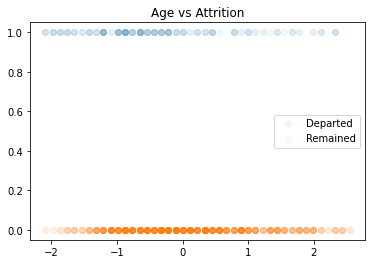

In [416]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

didEmployeeDepart = ret_clean['Attrition']==1
departed = ret_clean[didEmployeeDepart]
remained = ret_clean[np.invert(didEmployeeDepart)]


x1 = departed['Age']
y1 = [1]* x1.size

x2 = remained['Age']
y2 = [0]* x2.size

fig, ax = plt.subplots()

ax.scatter(x1,y1, label='Departed', alpha = 0.05)
ax.scatter(x2, y2, label='Remained', alpha = 0.05)

plt.title('Age vs Attrition')

ax.legend()


plt.show()

A first idea was to look at the ages of the employees alone. This had an interesting effect, showing that while there was not a lot of clustering beyond the normal distribution in those that `Remained`, the `Departed` employees skew younger. 

Next, we consider some compound ideas, for example `JobLevel` and `MonthlyIncome`

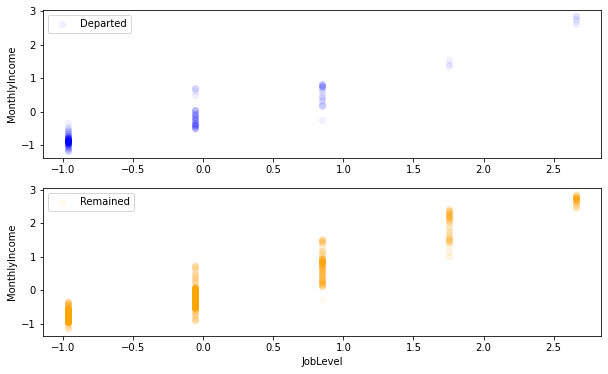

In [417]:
xVar = 'JobLevel'
yVar = 'MonthlyIncome'

x1 = departed[xVar]
y1 = departed[yVar]

x2 = remained[xVar]
y2 = remained[yVar]

fig, ax = plt.subplots(2, figsize=(10, 6))

ax[0].scatter(x1,y1, label='Departed', alpha = 0.05, color ='blue')
ax[0].legend()
ax[0].set_ylabel(yVar)

ax[1].scatter(x2, y2, label='Remained', alpha = 0.05, color = 'orange')
ax[1].legend()
ax[1].set_xlabel(xVar)
ax[1].set_ylabel(yVar)



plt.show()

This comparison brings out what is pretty intuitive: higher monthly incomes correlate to higher job levels, and departures concetrate in the lower levels of job type. 

---
We can finish by showing what the average employee in each class looks like. This can help to identify more areas to look for clearer correlations in. We sort the set by relative difference to indicate areas of interest for futher examination.

<AxesSubplot:>

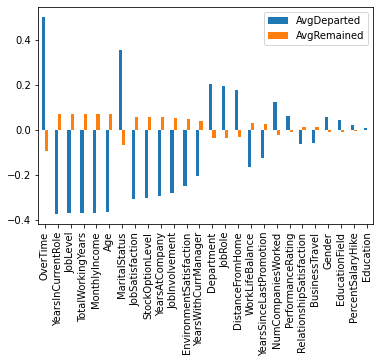

In [418]:
departedAvg = departed.mean()
remainedAvg = remained.mean()

avgEmployees = pd.DataFrame({ 'AvgDeparted': departedAvg, 'AvgRemained': remainedAvg }).drop('Attrition')

#we add an additionalcolumn to show relative difference and help sort the data for our interests
avgEmployees['abs_diff'] = abs(avgEmployees.AvgRemained - avgEmployees.AvgDeparted)

avgEmployees = avgEmployees.sort_values(by='abs_diff', ascending = False)

avgEmployees.plot(y=['AvgDeparted', 'AvgRemained'], kind='bar')

### Basic Conclusions and Future Work

From this averaging exercise, it apears that the following are good places to look for predictors of employee departures:

1. More overtime
2. Less tenured (YearsInRole, TotalWorkingYears)
3. Less compensated (JobLevel, Monthly Income)
4. Less settled (younger, unmarried)

Other areas seem like they may not be able to help in this aspect, and should probably not be used going forward:

1. Education
2. Gender
3. Salary hikes

These conclusions are in line with my personal expectations, and leave us in a good place after this Exploratory Data Analysis.